# 1、读入数据、英文文本预处理

# 数据处理

In [36]:
import nltk

# nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

# 添加新的停用词
new_stop_words = ['user', 'ensure', 'would ','well ', 'necessary', 'could ''even', 'high', 'need ','include']
stop_words.extend(new_stop_words)

# 打印停用词列表长度和前7个停用词
print(len(stop_words))
print(stop_words[:7])

# 打印长度为1的停用词
print([sw for sw in stop_words if len(sw) == 1])


188
['i', 'me', 'my', 'myself', 'we', 'our', 'ours']
['i', 'a', 's', 't', 'd', 'm', 'o', 'y']


In [37]:
import pandas as pd
papers = pd.read_excel("LDA4Patent.xlsx",names= ['Abstract','Time'])
papers.head()

,Abstract,Time
0,What methods does your organization currently ...,NaN
1,In the event of unexpected service interruptio...,NaN
2,How would the 'Data Lifeboat' concept fit with...,NaN
3,If your organization were to build a 'Data Lif...,NaN
4,How would you determine which data is importan...,NaN


In [38]:
## 导入英文文本预处理相关函数

## 英文分词
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
## 词形还原
import string
from nltk.stem.wordnet import WordNetLemmatizer
# 词干化
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

In [39]:
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

nlp = spacy.load("en_core_web_sm")

def paperCut(text):
    ## 1、英文分词
    token_word = word_tokenize(text)
    
    ## 2、去停用词
    # 加载标点符号
    punctuations = list(string.punctuation)
    ## 加载停用词
    stop_words = set(stopwords.words("english"))
    remove_word = []
    for w in token_word:    
        if w not in stop_words:
            if w not in punctuations:
                remove_word.append(w)
    
    ## 3、词形还原
    doc = nlp(" ".join(remove_word))
    lem_word = [token.lemma_ for token in doc]
    
    ## 4、词组处理
    tokenizer = MWETokenizer([('business', 'environment'), ('world', 'bank'), ('supply', 'chain'), ('doing', 'business'), ('sustainable', 'development')], separator=' ')
    tokenized_text = tokenizer.tokenize(lem_word)
    
    ## 5、词汇归一化
    normalized_word = []
    for w in tokenized_text:
        if w == "companies" or w == "company" or w == "corporate":
            normalized_word.append("firms")
        else:
            normalized_word.append(w)
    
    return normalized_word


In [40]:
## 进行英文文本预处理
wordList  = [paperCut(paper) for paper in papers.Abstract]
wordList[:1]

[['what',
  'method',
  'organization',
  'currently',
  'employ',
  'preserve',
  'digital',
  'datum',
  'how',
  'ensure',
  'long',
  '-',
  'term',
  'accessibility',
  'content']]

# 2、构建词袋模型、TF-IDF计算

In [41]:
## 导包
from gensim import corpora,models

dict = corpora.Dictionary(wordList)
## 生成文档稀疏向量
corpus = [dict.doc2bow(text) for text in wordList] ## list in list

## 进行TF-IDF计算
tfidf_model = models.TfidfModel(corpus)
corpus_tfidf = tfidf_model[corpus]

# 构建TF-IDF>0.1的关键词
p = 0.2
new_corpus_tfidf = []
for doc in corpus_tfidf:
    new_doc = [(id, tfidf) for id, tfidf in doc if tfidf >= p]
    new_corpus_tfidf.append(new_doc)

new_corpus_tfidf

[[(1, 0.2677926117669869),
  (2, 0.22623166607819764),
  (3, 0.5337668244166821),
  (6, 0.2677926117669869),
  (8, 0.3031154556628188),
  (9, 0.20148061416949972),
  (10, 0.24926299575654767),
  (11, 0.3031154556628188),
  (14, 0.3552481933387419)],
 [(8, 0.2228096077458387),
  (15, 0.2793242020343552),
  (16, 0.246265283632103),
  (17, 0.2793242020343552),
  (18, 0.26113056636172083),
  (19, 0.246265283632103),
  (20, 0.2228096077458387),
  (21, 0.2793242020343552),
  (22, 0.4092319441464087),
  (24, 0.21320636522985076),
  (25, 0.246265283632103),
  (27, 0.26113056636172083),
  (28, 0.246265283632103)],
 [(8, 0.26487816476958664),
  (10, 0.2178190640810085),
  (33, 0.23401121328038807),
  (34, 0.4664334141498002),
  (35, 0.3992483310230624),
  (36, 0.33206324789632446),
  (38, 0.29276249365934914),
  (39, 0.2778210403451034),
  (40, 0.3104344820804847)],
 [(8, 0.2684909795796728),
  (11, 0.2684909795796728),
  (42, 0.3648570941009574),
  (43, 0.3365924359512505),
  (44, 0.25691883950

In [42]:
import gensim

print('关键词数量: %d' % len(dict))
print('实验语料数量: %d' % len(corpus))

关键词数量: 952
实验语料数量: 123


# 3、LDA建模及结果阶段

## 3.1  确定最优主题数目

In [43]:
from gensim.models.ldamodel import LdaModel

In [44]:
## 用于主题一致性计算过程中的参数处理
texts = [[dict[word_id] for word_id, freq in doc] for doc in corpus]

In [45]:
## 计算主题一致性

model_list = []

## 遍历主题数量从5个从20个
for i in range(5,10):
    ldamodel = LdaModel(corpus_tfidf, id2word= dict,num_topics= i,passes=5,alpha= 1/i, eta=0.01)
    ## 一致性算法u_mass、c_v、c_uci、c_npmi
    top_topics = ldamodel.top_topics(texts=texts, corpus=corpus, dictionary=dict, coherence='c_npmi')
    avg_topic_coherence = sum([t[1] for t in top_topics]) / i
    model_list.append((ldamodel, avg_topic_coherence))
    print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -0.1702.
Average topic coherence: -0.2911.
Average topic coherence: -0.1780.
Average topic coherence: -0.2129.
Average topic coherence: -0.2651.


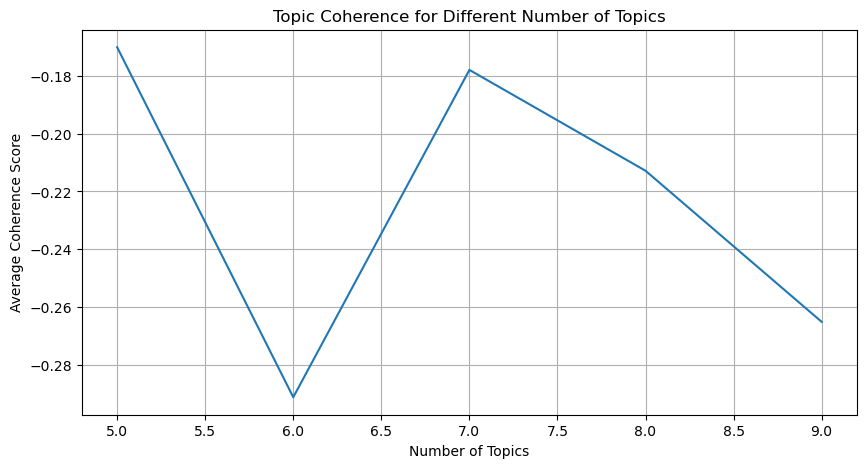

In [46]:
import matplotlib.pyplot as plt

# 创建两个列表，一个用于存放主题数量，另一个用于存放主题一致性得分
num_topics = [i for i in range(5, 10)]
coherence_values = [coherence for _, coherence in model_list]

# 绘制图形
plt.figure(figsize=(10, 5))
plt.plot(num_topics, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Average Coherence Score")
plt.title("Topic Coherence for Different Number of Topics")
plt.grid(True)
plt.show()


Perplexity for 5 topics: -20.3782
Perplexity for 6 topics: -20.5332
Perplexity for 7 topics: -20.8302
Perplexity for 8 topics: -21.0553
Perplexity for 9 topics: -21.5144


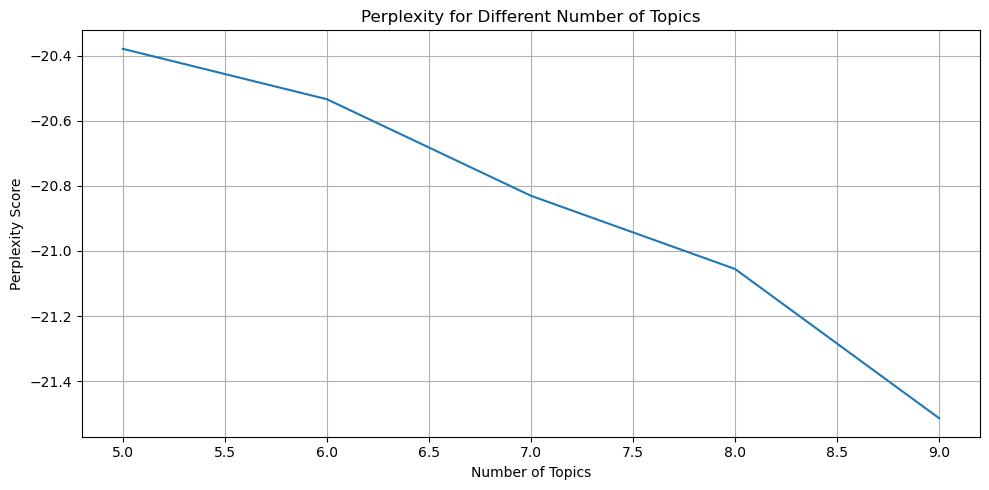

In [36]:
import matplotlib.pyplot as plt

# 创建两个列表，一个用于存放主题数量，另一个用于存放困惑度得分
num_topics = [i for i in range(5, 10)]
perplexity_values = []

# 遍历主题数量
for i in num_topics:
    ldamodel = LdaModel(corpus_tfidf, id2word=dict, num_topics=i, passes=5, alpha=1/i, eta=0.01)
    perplexity = ldamodel.log_perplexity(corpus_tfidf)  # 使用log_perplexity方法计算困惑度得分
    perplexity_values.append(perplexity)
    print('Perplexity for %d topics: %.4f' % (i, perplexity))

# 绘制困惑度图形
plt.figure(figsize=(10, 5))
plt.plot(num_topics, perplexity_values)
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity Score")
plt.title("Perplexity for Different Number of Topics")
plt.grid(True)

plt.tight_layout()  # 调整子图布局，防止重叠
plt.show()

In [47]:
## 获得最优主题模型
ldamodel, tc = max(model_list, key=lambda x: x[1])
print('Topic coherence: %f' %tc)
print('最优主题数目: %d' %ldamodel.num_topics)

Topic coherence: -0.170175
最优主题数目: 5


## 3.2  进行LDAvis可视化

In [48]:
## pip install pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook

<function pyLDAvis._display.enable_notebook(local=False, **kwargs)>

In [49]:
# 如果能登陆外网，采用此种方式
topic_data = pyLDAvis.gensim.prepare(ldamodel,corpus,dict)
pyLDAvis.display(topic_data)

E:\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


In [50]:
##如果不能登陆外网，则需要用下述方式
topic_data = pyLDAvis.gensim.prepare(ldamodel,corpus,dict)
pyLDAvis.save_html(topic_data,'save_blockchain.html')

E:\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


## 3.3 主题展示，绘制词云

In [41]:
## 列出主题和主题词
ldamodel.print_topics(num_topics=ldamodel.num_topics,num_words= 10)

[(0,
  '0.002*"family" + 0.002*"business" + 0.002*"ethnic" + 0.002*"enterprise" + 0.002*"child" + 0.002*"energy" + 0.002*"system" + 0.002*"firm" + 0.002*"carbon" + 0.002*"soil"'),
 (1,
  '0.003*"tourism" + 0.003*"risk" + 0.003*"management" + 0.003*"crisis" + 0.003*"disaster" + 0.003*"organizational" + 0.003*"business" + 0.002*"performance" + 0.002*"employee" + 0.002*"resilience"'),
 (2,
  '0.003*"governance" + 0.003*"adaptation" + 0.003*"organizational" + 0.003*"climate" + 0.002*"innovation" + 0.002*"change" + 0.002*"system" + 0.002*"knowledge" + 0.002*"transformation" + 0.002*"team"'),
 (3,
  '0.004*"firm" + 0.003*"business" + 0.003*"environmental" + 0.002*"crisis" + 0.002*"change" + 0.002*"innovation" + 0.002*"organization" + 0.002*"organizational" + 0.002*"sustainability" + 0.002*"system"'),
 (4,
  '0.004*"capital" + 0.003*"organizational" + 0.003*"identity" + 0.003*"firm" + 0.002*"business" + 0.002*"safety" + 0.002*"management" + 0.002*"crisis" + 0.002*"service" + 0.002*"social"')]